In [8]:
import torch
import torchvision
torch.__version__

'2.3.0+cu121'

In [9]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [12]:
train_dir=data_20_percent_path/'train'
test_dir=data_20_percent_path/'test'

In [13]:
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms=effnetb2_weights.transforms()

effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad=False

In [14]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [15]:
effnetb2.classifier=nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features=1408,out_features=3)
)

In [16]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
    effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT

    effnetb2_transforms=effnetb2_weights.transforms()

    effnestb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)

    for param in effnestb2.parameters():
        param.requires_grad=False
        
    effnestb2.classifier=nn.Sequential(
        nn.Dropout(p=0.3,inplace=True),
        nn.Linear(in_features=1408,out_features=num_classes)
    )
    
    return effnestb2,effnetb2_transforms

In [17]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [18]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [19]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [20]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=effnetb2.parameters(),lr=1e-3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()

effnetb2_results=engine.train(model=effnetb2,
                            train_dataloader=train_dataloader_effnetb2,
                            test_dataloader=test_dataloader_effnetb2,
                            epochs=1,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            device=device
                            )

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9872 | train_acc: 0.5437 | test_loss: 0.7549 | test_acc: 0.9006


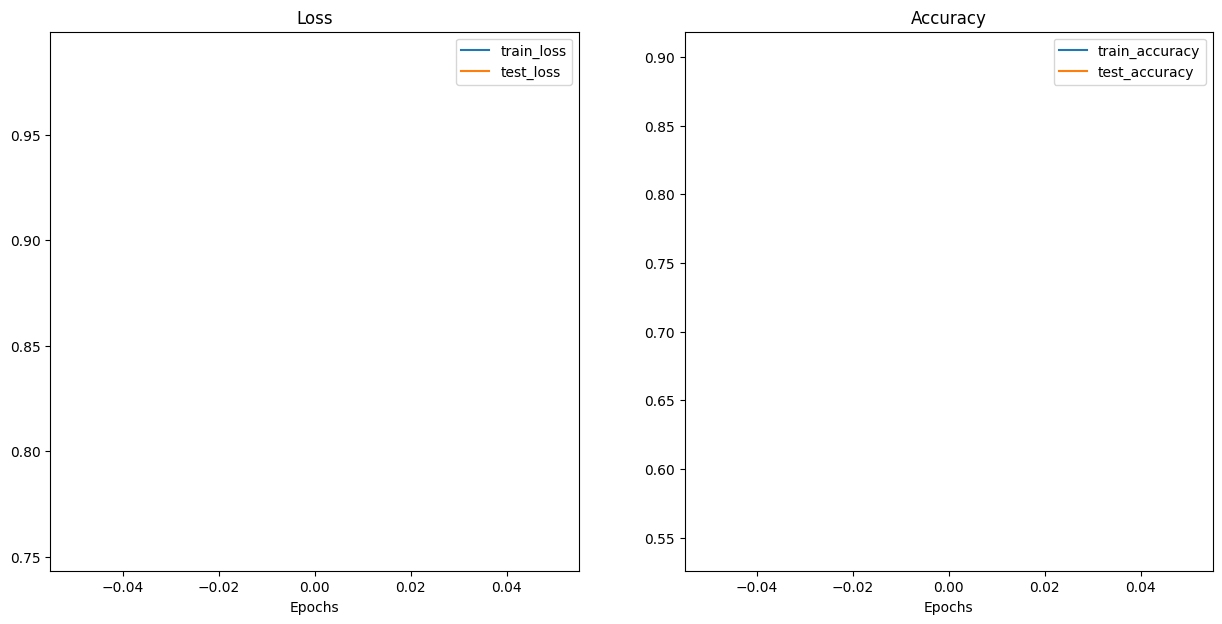

In [21]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [22]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,target_dir='models',
                 model_name='pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [23]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [24]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [25]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.7549432754516602,
 'test_acc': 0.9005681818181819,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [26]:
vit=torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [28]:
vit, vit_transforms=create_vit_model(num_classes=3,seed=42)

In [29]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [30]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [31]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=vit.parameters(),lr=1e-3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
vit_results=engine.train(model=vit,
                         train_dataloader=train_dataloader_vit,
                         test_dataloader=test_dataloader_vit,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=1,
                         device=device
                         )

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


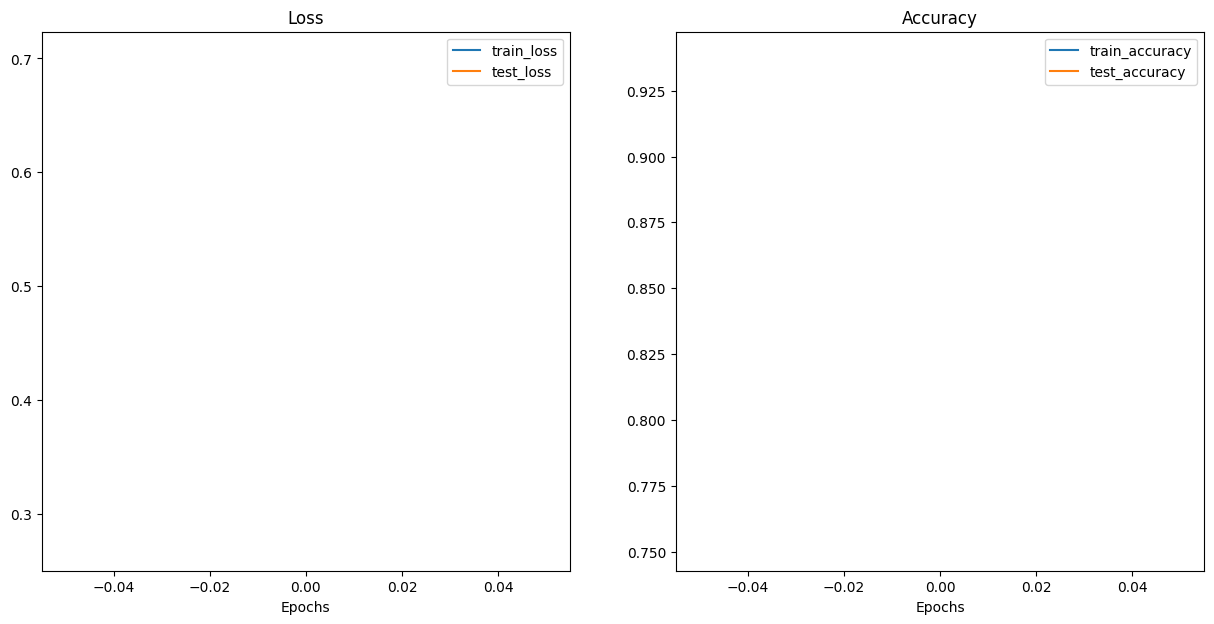

In [32]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [33]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir='models',
                 model_name='pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [34]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [35]:
vit_total_params=sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [36]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.2713926747441292,
 'test_acc': 0.9380681818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [37]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [38]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device:str ='cuda' if torch.cuda.is_available() else 'cpu',
                )-> List[Dict]:
    
    pred_list=[]
    
    for path in tqdm(paths):
        
        pred_dict={}
        pred_dict['image_path']=path
        class_name=path.parent.stem
        pred_dict['class_name']=class_name
        
        start_time=timer()
        
        img=Image.open(path)
        transformed_image=transform(img).unsqueeze(0).to(device)
        
        model.to(device)
        model.eval()
        with torch.inference_mode():
            
            pred_logit=model(transformed_image)
            pred_prob=torch.softmax(pred_logit,dim=1)
            pred_label=torch.argmax(pred_prob,dim=1)
            pred_class=class_names[pred_label.cpu()]
            
            pred_dict['pred_prob']=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
            pred_dict['pred_class']=pred_class
            
            end_time=timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
            
        pred_dict['correct']=class_name==pred_class
        pred_list.append(pred_dict)
        
    return pred_list

In [39]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5926,
  'pred_class': 'pizza',
  'time_for_pred': 1.2864,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.3902,
  'pred_class': 'pizza',
  'time_for_pred': 0.7013,
  'correct': True}]

In [41]:
import pandas as pd

effnetb2_test_pred_df=pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5926,pizza,1.2864,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.3902,pizza,0.7013,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7159,pizza,0.6596,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5000,pizza,0.5235,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4978,pizza,0.4700,True


In [42]:
effnetb2_test_pred_df.correct.value_counts()

True     135
False     15
Name: correct, dtype: int64

In [43]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.4693 seconds


In [44]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.7549432754516602,
 'test_acc': 0.9005681818181819,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.4693}

In [45]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [46]:
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9654,
  'pred_class': 'pizza',
  'time_for_pred': 1.2203,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9336,
  'pred_class': 'pizza',
  'time_for_pred': 0.6976,
  'correct': True}]

In [47]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9654,pizza,1.2203,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9336,pizza,0.6976,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9736,pizza,0.5464,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.8667,pizza,0.5583,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7392,pizza,0.5836,True


In [48]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     141
False      9
Name: correct, dtype: int64

In [49]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6778 seconds


In [50]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.2713926747441292,
 'test_acc': 0.9380681818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6778}

In [57]:
df= pd.DataFrame([effnetb2_stats,vit_stats])
df['model']=['effnetb2','vit']
df['test_acc']=round(df['test_acc']*100,2)
df


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.754943,90.06,7705221,29,0.4693,effnetb2
1,0.271393,93.81,85800963,327,0.6778,vit


In [54]:
pd.DataFrame(data=df.set_index('model').loc['vit']/df.set_index('model').loc['effnetb2']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
0,0.359488,1.04164,11.135432,11.275862,1.444279


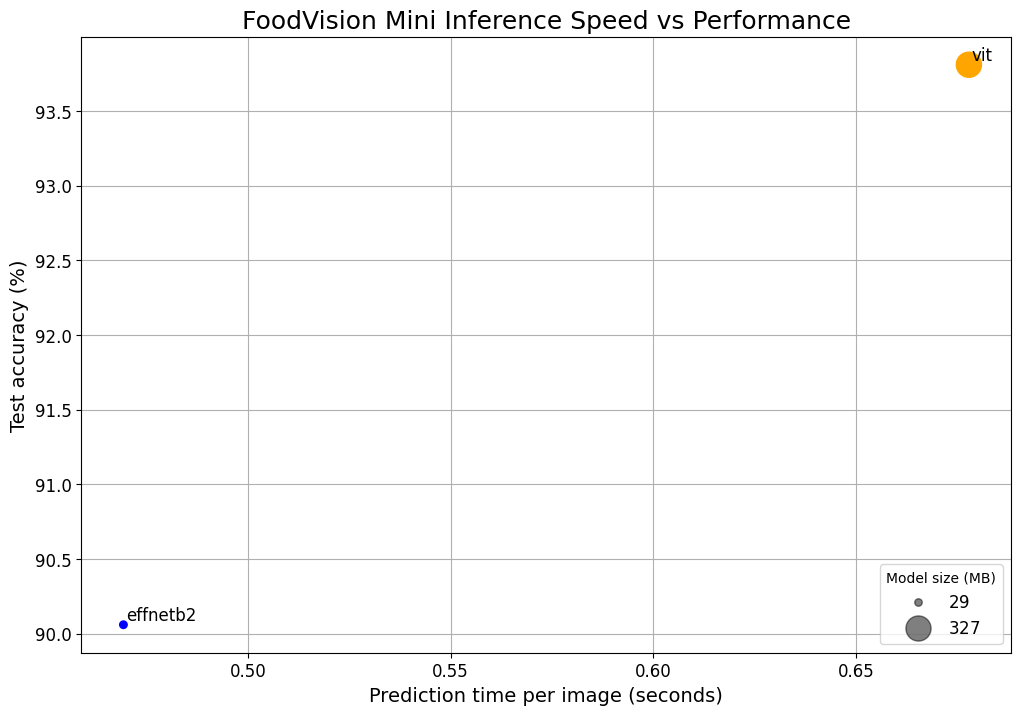

In [58]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
# plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [60]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.7.2 requires urllib3[socks]~=1.26, but you have urllib3 2.2.1 which is incompatible.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


Gradio version: 4.36.1


In [61]:
effnetb2.cpu()

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [62]:
from typing import Tuple, Dict

def predict(img)-> Tuple[Dict,float]:
    start_time=timer()
    img=effnetb2_transforms(img).unsqueeze(0)
    
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs=torch.softmax(effnetb2(img),dim=1)
        
    pred_labels_probs={class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    pred_time=round(timer()-start_time,5)
    
    return pred_labels_probs,pred_time
    

In [63]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\steak\864661.jpg

Prediction label and probability dictionary: 
{'pizza': 0.21057943999767303, 'steak': 0.4165714979171753, 'sushi': 0.37284907698631287}
Prediction time: 0.89278 seconds


In [64]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\2353677.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\2111981.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\3401466.jpg']]

In [1]:
import gradio as gr

title='FoodVision Mini'
description="An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article="Created in sleep"

demo=gr.Interface(fn=predict,
                  inputs=gr.Image(type='pil'),
                  outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                            gr.Number(label="Prediction time (s)")],
                  examples=example_list,
                  title=title,
                  description=description,
                  article=article
                )

demo.launch(debug=False, share=True)

NameError: name 'predict' is not defined